## Load Packages

In [1]:
using OffsetArrays

#using Dates            #Julia 0.7
using Compat, Missings  #to use 0.7 syntax in 0.6


include("printmat.jl")

INFO: Precompiling module OffsetArrays.


printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

# Risk Neutral Pricing

Let $f_u$ and $f_d$ be the value of the derivative in the up- and down-state next period. Then, the value today is

$f  =e^{-yh}\left[  pf_{u}+\left(  1-p\right)  f_{d}\right] \ \text{ with } \ p=\frac{e^{yh}-d}{u-d}$


In [3]:
   
S = 10                          #underlying price
u = 1.1                         
d = 0.95
K = 10                          #strike price: try different values
y = 0                           #interest rate
h = 1/12                        #time to expiration

fu = max(S*u-K,0)               #value of call option in up node 
fd = max(S*d-K,0)               #in down node
printlnPs("Payoffs in (u,d) at expiration of call option with strike $K: ",[fu fd])

p = (exp(y*h) - d)/(u-d)
printlnPs("Risk-neutral probability of up: ",p)

C = exp(-y*h)*(p*fu+(1-p)*fd)
printlnPs("Price of call option with strike $K: ",C)

Payoffs in (u,d) at expiration of call option with strike 10:      1.000     0.000
Risk-neutral probability of up:      0.333
Price of call option with strike 10:      0.333


# A CRR Tree

The CRR approach to construct $(u,d)$ for a small time step of length $h$ is 

$u=e^{\sigma\sqrt{h}} \ \text{ and }\ d=e^{-\sigma\sqrt{h}}$,

where $\sigma$ is the standard deviation of the underlying for a full period (often a year)

In [4]:
m = 0.5                 #time to experiation (in years)                
y = 0.05                #interest rate (annualized) 

σ = 0.2                 #annualized std of underlying asset
n = 50                  #number of time steps of size h 
h = m/n                 #time step size (in years)

u = exp(σ*sqrt(h))
d = exp(-σ*sqrt(h))
p = (exp(y*h) - d)/(u-d)

printlnPs("(u,exp(yh),d,p) when σ=$σ and h=$h: ",[u exp(y*h) d p])

printlnPs("\nChecking if u > safe gross return > d: ",u > exp(y*h) > d)

(u,exp(yh),d,p) when σ=0.2 and h=0.01:      1.020     1.001     0.980     0.508

Checking if u > safe gross return > d:       true


### Build a Tree for the Underlying Asset

We create a tree by starting at the current spot price $S$. The future nodes are then created by multiplying by $u$ or $d$

$\text{step 0}: (S)$

$\text{step 1}: (Su,Sd)$

$\text{step 2}: (Suu,Sud,Sdd)$ (since $Sud=Sdu$)

...

A figure (see below) illustrates how these values are stored in an array of vectors

In [5]:
function BuildSTree(S,n,u,d)
    STree = OffsetArray(Any,0:n)        #construct 0 based vector of vectors (1 based) with different lengths
    for i = 0:n                         #not elegant, but works            
        STree[i] = fill(NaN,i+1)        #STree[i] is a vector with i+1 elements
    end         
    STree[0] = [S]                      #time node 0, element 1 
    for i = 1:n                        #move forward in time
        for j = 1:i    
            STree[i][j] = u*STree[i-1][j]       #time node i, element j: up move from all in STree[i-1]
        end
        STree[i][end] = d*STree[i-1][end]       #down move from STree[i-1][end] 
    end
    return STree    
end

BuildSTree (generic function with 1 method)

In [6]:
S = 42.0                             #current price of underlying asset

STree = BuildSTree(S,n,u,d)
println("printing the first 3 time steps in the tree")
for i = 0:2
    printmat(STree[i])
end 

println("\nYes, the vectors are of different lengths")

printing the first 3 time steps in the tree
    42.000

    42.848
    41.168

    43.714
    42.000
    40.353


Yes, the vectors are of different lengths


### Plotting the Tree for the Underlying Asset

The next figures illustrate how these nodes are put into an array of vectors and then shows the entire tree

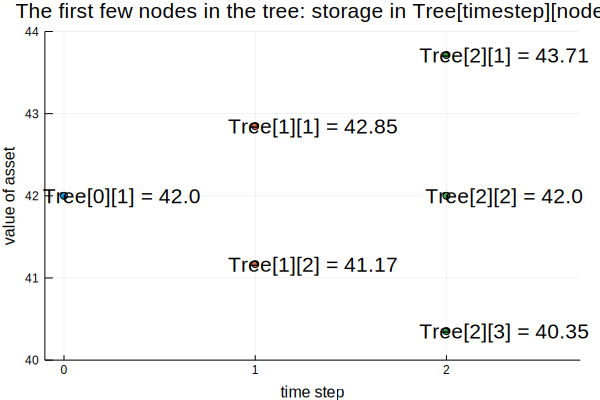

In [7]:
plot(legend=false,xlim=(-0.1,2.7),ylim=(40,44),xticks=0:2)
for i = 0:2
    scatter!(fill(i,i+1),STree[i])
    for j = 1:length(STree[i])
        txt = string("Tree[$i][$j] = ",round(STree[i][j],2))
        annotate!(i+0.3,STree[i][j],txt)
    end    
end    
title!("The first few nodes in the tree: storage in Tree[timestep][node]")
xlabel!("time step")
ylabel!("value of asset")

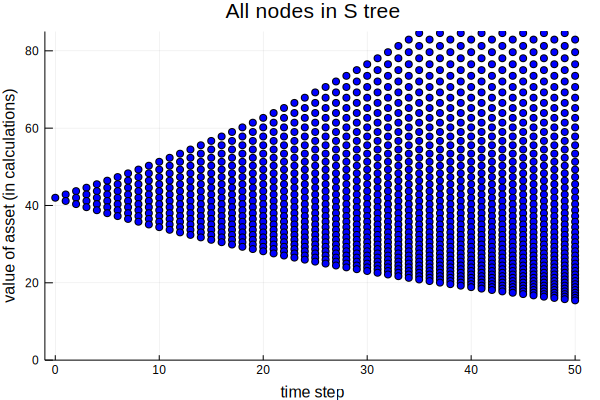

In [8]:
scatter([0.0],STree[0],color=:blue)
for i = 1:n
    scatter!(fill(i,i+1),STree[i],color=:blue)  
end
plot!(xlim=(-1,n+0.5),ylim=(0,85),legend=false,)
title!("All nodes in S tree")
xlabel!("time step")
ylabel!("value of asset (in calculations)")

# Calculating the Option Price

Let $f_{ij}$ be the option price at time step $i$ when the underlying price is $S_{ij}$. (We use $S_{ij}$ as a shorthand notation, to avoid having to write things like $Sudd$.) In the code below, $S_{i1}$ is the highest node in time step $i$, $S_{i2}$ is the second highest, etc.

For a European call option, the call price at the last time step $n$ is 
$f_{nj} = \max(0,S_{nj}-K)$. 

Instead, the put price is 
$f_{nj} = \max(0,K-S_{nj})$. 

For all earlier time steps, the value is 

$f_{ij} = e^{-yh}[p f_{i+1,j} + (1-p) f_{i+1,j+1}]$

For instance,

$f_{i1} = e^{-yh}[p f_{i+1,1} + (1-p) f_{i+1,2}]$

$f_{i2} = e^{-yh}[p f_{i+1,2} + (1-p) f_{i+1,3}]$

### European Options

In [9]:
function EuOptionPrice(STree,K,y,n,h,u,d,p,isPut=false)     #price of European option
    Value = OffsetArray(Any,0:n)        #construct 0 based vector of vectors (1 based) with different lengths
    for i = 0:n                         #not elegant, but works            
        Value[i] = fill(NaN,i+1)        #Value[i] is a vector with i+1 elements
    end               
    if isPut 
        Value[n] = max.(0,K-STree[n])            #put, at last time node
    else
        Value[n] = max.(0,STree[n]-K)            #call, at last time node    
    end    
    for i = n-1:-1:0                            #move backward in time
        for j = 1:i+1                           #loop over S nodes at time node i            
            fa  = exp(-y*h)*(p*Value[i+1][j] + (1-p)*Value[i+1][j+1])
            Value[i][j] = fa 
        end
    end
    return Value
end

EuOptionPrice (generic function with 2 methods)

In [10]:
K = 42.0                                  #strike price 

Pe = EuOptionPrice(STree,K,y,n,h,u,d,p,true)             #Pe[1][1] contains the put price (node 0)
Ce = EuOptionPrice(STree,K,y,n,h,u,d,p,false)

printlnPs("European put and call prices at K=$K and S=$S, ",[Pe[0] Ce[0]])

printlnPs("\nCall price according to put-call partity (taking put price as given): ",Pe[0][1] + S - exp(-m*y)*K)

println("\n(Pe[0][1] is a 1x1 vector, so we must extract the first (and only) element to make it a scalar.)")

European put and call prices at K=42.0 and S=42.0,      1.844     2.881

Call price according to put-call partity (taking put price as given):      2.881

(Pe[0][1] is a 1x1 vector, so we must extract the first (and only) element to make it a scalar.)


### American Options

The option values are calculated as for the European option, except that that the option value is 

$f_{ij} = \max(\text{value if excercised now},\text{continuation value})$

The continuation value has the same form (but possible different numbers) as in the European case. Clearly, the value of exercising now is $S_{ij}-K$ for a call and $K-S_{ij}$ for a put.

In [11]:
function AmOptionPrice(STree,K,y,n,h,u,d,p,isPut=false)     #price of American option
    Value = OffsetArray(Any,0:n)        #construct 0 based vector of vectors (1 based) with different lengths
    for i = 0:n                         #not elegant, but works            
        Value[i] = fill(NaN,i+1)        #Value[i] is a vector with i+1 elements
    end                   
    if isPut 
        Value[n] = max.(0,K-STree[n])            #put, at last time node
    else
        Value[n] = max.(0,STree[n]-K)            #call, at last time node    
    end    
    for i = n-1:-1:0                              #move backward in time
        for j = 1:i+1                             #loop over S nodes at time node i            
            fa  = exp(-y*h)*(p*Value[i+1][j] + (1-p)*Value[i+1][j+1])
            if isPut 
                Value[i][j] = max(K-STree[i][j],fa)         #put
            else
                Value[i][j] = max(STree[i][j]-K,fa)         #call       
            end    
        end
    end
    return Value
end

AmOptionPrice (generic function with 2 methods)

In [12]:
K = 42.0                                  #strike price 

Pa = AmOptionPrice(STree,K,y,n,h,u,d,p,true)
Ca = AmOptionPrice(STree,K,y,n,h,u,d,p,false)

printlnPs("American put and call prices at K=$K and S=$S, ",[Pa[0] Ca[0]])

printlnPs("\nCompare with European put and call prices, ",[Pe[0] Ce[0]])

println("\nInteresting exercise: change function to store also the nodes of early exercise---and then plot it")

American put and call prices at K=42.0 and S=42.0,      1.950     2.881

Compare with European put and call prices,      1.844     2.881

Interesting exercise: change function to store also the nodes of early exercise---and then plot it


## Plotting the Tree of the Options

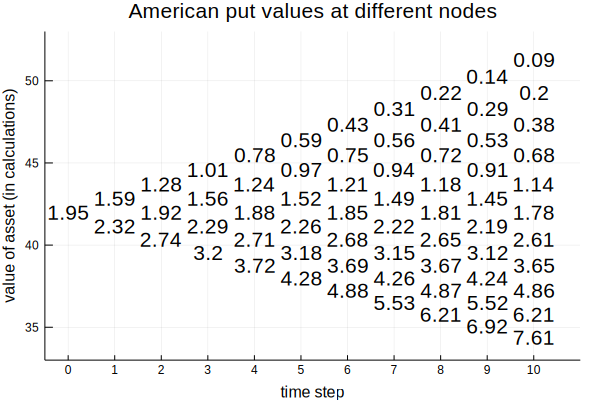

In [14]:
plot(xlim=(-0.5,11),ylim=(33,53),xticks=0:10,legend=false)
for i = 0:10
    for j = 1:length(STree[i])
        annotate!(i,STree[i][j],string(round(Pa[i][j],2)))
    end    
end    
plot!()
title!("American put values at different nodes")
xlabel!("time step")
ylabel!("value of asset (in calculations)")